In [19]:
import pandas as pd
import os
import re
import sys
import numpy as np
from merf import MERF
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
sns.set_context("poster")
from sklearn.ensemble import RandomForestRegressor
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (11,8)
from merf.merf import MERF
from sklearn.model_selection import train_test_split, KFold
from merf.viz import plot_merf_training_stats

current_dir = os.getcwd() # Get the current working directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
from em_utils import *

# Create output directory if it doesn't exist
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/5.combined/jan15_5foldcv"
df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/5.combined"
os.makedirs(output_dir, exist_ok=True)

# Read in combined test and train sets 
test_all = pd.read_csv(os.path.join(df_dir, 'test_merged_all_omics_raw_meta.csv'))  # Read in test_micom_no_na
train_all = pd.read_csv(os.path.join(df_dir, 'training_merged_all_omics_raw_meta.csv'))  # Read in train_micom_no_na

### Select testinng and training predictors 

In [20]:
print("---------- Select predictors for training set ----------")
train_set = train_all
X = train_set.drop(['Unnamed: 0_y','Unnamed: 0_x', 'Unnamed: 0_train_long', 'Unnamed: 0_merged_data',
                    'sample_id','all_samples', 'all_samples_x', 'all_samples_y', 'record_id', 'subject_id','SampleID',
                    'time_x', 'time_y', 'x_t', 't', 'time',
                    'outcome_BMI_fnl_x', 'outcome_BMI_fnl_y', 'outcome_BMI_fnl_merged_data','outcome_BMI_fnl_train_long',
                    'old_or_new', 'predicted_BL_BMI', 'differences_BL_BMI', 'diff_BMI_quartile', 'diff_BMI_std',
                    'methyl_bmi_rs', 'methyl_bmi_rs_standardized'], 
                    axis=1)

#X = X.drop(columns=['Unnamed: 0_tax', 'x_t'], errors='ignore')
Y = train_set[['outcome_BMI_fnl_train_long']]
Y = Y['outcome_BMI_fnl_train_long'].to_numpy() # Convert Y to numeric array
clusters_train = train_set['all_samples'].to_numpy() # Get ID variables
Z = np.ones((train_set.shape[0], 1)) # Create random effects matrix with ones

print("X shape: ", X.shape)
print("X data: \n", X)

print("---------- Select predictors for test set ----------")
print("---------- Select predictors for test set ----------")
test_set = test_all
X_new = test_set.drop(['Unnamed: 0_y','Unnamed: 0_x', 'Unnamed: 0_test_long', 'Unnamed: 0_merged_data',
                    'sample_id','all_samples', 'all_samples_x', 'all_samples_y', 'record_id', 'subject_id', 
                    'time_x', 'time_y', 'x_t', 't', 'time',
                    'outcome_BMI_fnl_x', 'outcome_BMI_fnl_y', 'outcome_BMI_fnl_merged_data','outcome_BMI_fnl_test_long',
                    'old_or_new', 'predicted_BL_BMI', 'differences_BL_BMI', 'diff_BMI_quartile', 'diff_BMI_std',
                    'methyl_bmi_rs', 'methyl_bmi_rs_standardized'], 
                    axis=1)

X_new = X_new[X.columns]  # Reorder and select columns to match training set
X_new = X_new.astype(X.dtypes)  # Ensure data types match

Y_new = test_set['outcome_BMI_fnl_test_long'].to_numpy()  # Convert Y to numeric array
clusters_new = pd.Series(test_set['all_samples'])  # Convert to pandas Series
# Create random effects matrix with ones
Z_new = np.ones((len(X_new), 1))

print("X_new shape: ", X_new.shape)
print("X_new data: \n", X_new)

---------- Select predictors for training set ----------
X shape:  (268, 608)
X data: 
      randomized_group  cohort_number  sex  race        age  Glucose  \
0                   1              1    0     5  43.861384     88.0   
1                   1              1    0     5  43.861384     91.0   
2                   1              1    0     5  43.861384     87.0   
3                   1              1    1     5  42.574568     87.0   
4                   1              1    1     5  42.574568     81.0   
..                ...            ...  ...   ...        ...      ...   
263                 1              5    0     5  50.109060    103.0   
264                 1              5    0     5  50.109060     82.0   
265                 1              5    0     5  50.109060     89.0   
266                 1              5    1     5  44.115782    109.0   
267                 1              5    1     5  44.115782     86.0   

     HDL_Total_Direct_lipid   HOMA_IR  Insulin_endo  LDL_Ca

In [21]:
print("X shape: ", X.shape)
print("X data: \n", X)

X shape:  (268, 608)
X data: 
      randomized_group  cohort_number  sex  race        age  Glucose  \
0                   1              1    0     5  43.861384     88.0   
1                   1              1    0     5  43.861384     91.0   
2                   1              1    0     5  43.861384     87.0   
3                   1              1    1     5  42.574568     87.0   
4                   1              1    1     5  42.574568     81.0   
..                ...            ...  ...   ...        ...      ...   
263                 1              5    0     5  50.109060    103.0   
264                 1              5    0     5  50.109060     82.0   
265                 1              5    0     5  50.109060     89.0   
266                 1              5    1     5  44.115782    109.0   
267                 1              5    1     5  44.115782     86.0   

     HDL_Total_Direct_lipid   HOMA_IR  Insulin_endo  LDL_Calculated  ...  \
0                      47.0  2.151111   

In [22]:
print("X_new clusters: ", clusters_new.shape)
print("X_new clusters: \n", clusters_new)
print("Number of unique clusters in testing : ", clusters_new.nunique())

# ... existing code ...
clusters_train_count = pd.Series(train_set['all_samples']).to_numpy() # Convert to pandas Series
print("Number of unique clusters in training : ", pd.Series(clusters_train_count).nunique())  # Convert back to Series for nunique

X_new clusters:  (66,)
X_new clusters: 
 0       4
1       4
2       5
3       5
4       5
     ... 
61    167
62    167
63    187
64    187
65    187
Name: all_samples, Length: 66, dtype: int64
Number of unique clusters in testing :  24
Number of unique clusters in training :  96


### Read finetuned parameters 

In [23]:
df = pd.read_csv(os.path.join(df_dir, 'jan13_params_fine_tuning_results_all_omics.csv'))
# the line below filters out certain folds
df = df[df['n_splits'] == 5]
# Find the row with the lowest mean_mse_score
lowest_mse_row = df.loc[df['mean_mse_score'].idxmin()]
print("First 5 columns for the lowest mean_mse_score:")
print(lowest_mse_row.iloc[:5])

# Find the row with the lowest mean_prev_score
lowest_prev_row = df.loc[df['mean_prev'].idxmin()]
print("First 5 columns for the lowest mean_prev_score:")
print(lowest_prev_row.iloc[:5])

# Find the row with the lowest mean_prev_score
lowest_ptev_row = df.loc[df['mean_ptev'].idxmin()]
print("First 5 columns for the lowest mean_ptev_score:")
print(lowest_ptev_row.iloc[:5])

# Find the row with the highest oob_score
highest_oob_row = df.loc[df['oob_score'].idxmax()]
print("\nFirst 5 columns for the highest oob_score:")
print(highest_oob_row.iloc[:5])

First 5 columns for the lowest mean_mse_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits               5.00
Name: 19, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter               10.00
n_splits                5.00
Name: 40, dtype: float64


In [24]:
# Extract the rows for the parameter grids
lowest_mse_row = df.loc[df['mean_mse_score'].idxmin()]
lowest_prev_row = df.loc[df['mean_prev'].idxmin()]
lowest_ptev_row = df.loc[df['mean_ptev'].idxmin()]
highest_oob_row = df.loc[df['oob_score'].idxmax()]

# Create parameter grids from the extracted rows
best_mse_param_grid = {
    'n_estimators': [int(lowest_mse_row['n_estimators'])],
    #'max_depth': [int(lowest_mse_row['max_depth'])],
    'max_depth': [None if pd.isna(lowest_mse_row['max_depth']) else int(lowest_mse_row['max_depth'])],
    'min_samples_split': [float(lowest_mse_row['min_samples_split'])],
    #'min_samples_split': [float(lowest_mse_row['min_samples_split']) if lowest_mse_row['min_samples_split'] != 0 else 0.0],  # Convert 0 to 0.0
    'max_iter': [int(lowest_mse_row['max_iter'])],
    'n_splits': [int(lowest_mse_row['n_splits'])]
}
print("Best MSE Parameter Grid:")
print("n_estimators:", best_mse_param_grid['n_estimators'][0])
print("max_depth:", best_mse_param_grid['max_depth'][0])
print("min_samples_split:", best_mse_param_grid['min_samples_split'][0])
print("max_iter:", best_mse_param_grid['max_iter'][0])
print("n_splits:", best_mse_param_grid['n_splits'][0])

lowest_prev_param_grid = {
    'n_estimators': [int(lowest_prev_row['n_estimators'])],
    #'max_depth': [int(lowest_prev_row['max_depth'])],
    'max_depth': [None if pd.isna(lowest_prev_row['max_depth']) else int(lowest_prev_row['max_depth'])],
    'min_samples_split': [float(lowest_prev_row['min_samples_split'])],
    'max_iter': [int(lowest_prev_row['max_iter'])],
    'n_splits': [int(lowest_prev_row['n_splits'])]
}
print("\nLowest Prev Parameter Grid:")
print("n_estimators:", lowest_prev_param_grid['n_estimators'][0])
print("max_depth:", lowest_prev_param_grid['max_depth'][0])
print("min_samples_split:", lowest_prev_param_grid['min_samples_split'][0])
print("max_iter:", lowest_prev_param_grid['max_iter'][0])
print("n_splits:", lowest_prev_param_grid['n_splits'][0])

lowest_ptev_param_grid = {
    'n_estimators': [int(lowest_ptev_row['n_estimators'])],
    #'max_depth': [int(lowest_ptev_row['max_depth'])],
    'max_depth': [None if pd.isna(lowest_ptev_row['max_depth']) else int(lowest_ptev_row['max_depth'])],
    'min_samples_split': [float(lowest_ptev_row['min_samples_split'])],
    'max_iter': [int(lowest_ptev_row['max_iter'])],
    'n_splits': [int(lowest_ptev_row['n_splits'])]
}
print("\nLowest PTEV Parameter Grid:")
print("n_estimators:", lowest_ptev_param_grid['n_estimators'][0])
print("max_depth:", lowest_ptev_param_grid['max_depth'][0])
print("min_samples_split:", lowest_ptev_param_grid['min_samples_split'][0])
print("max_iter:", lowest_ptev_param_grid['max_iter'][0])
print("n_splits:", lowest_ptev_param_grid['n_splits'][0])

highest_oob_param_grid = {
    'n_estimators': [int(highest_oob_row['n_estimators'])],
    'max_depth': [None if pd.isna(highest_oob_row['max_depth']) else int(highest_oob_row['max_depth'])],
    'min_samples_split': [float(highest_oob_row['min_samples_split'])],
    'max_iter': [int(highest_oob_row['max_iter'])],
    'n_splits': [int(highest_oob_row['n_splits'])]
}
print("\Highest OOB Parameter Grid:")
print("n_estimators:", highest_oob_row['n_estimators'])
print("max_depth:", highest_oob_row['max_depth'])
print("min_samples_split:", highest_oob_row['min_samples_split'])
print("max_iter:", highest_oob_row['max_iter'])
print("n_splits:", highest_oob_row['n_splits'])

Best MSE Parameter Grid:
n_estimators: 500
max_depth: None
min_samples_split: 0.15
max_iter: 2
n_splits: 5

Lowest Prev Parameter Grid:
n_estimators: 500
max_depth: None
min_samples_split: 0.15
max_iter: 2
n_splits: 5

Lowest PTEV Parameter Grid:
n_estimators: 500
max_depth: None
min_samples_split: 0.05
max_iter: 2
n_splits: 5
\Highest OOB Parameter Grid:
n_estimators: 1000.0
max_depth: nan
min_samples_split: 0.05
max_iter: 10.0
n_splits: 5.0


<>:61: SyntaxWarning: invalid escape sequence '\H'
<>:61: SyntaxWarning: invalid escape sequence '\H'
/var/folders/4l/kqxc4rwn4lj10fzv9hw4xxsr0000gn/T/ipykernel_43968/2937010470.py:61: SyntaxWarning: invalid escape sequence '\H'
  print("\Highest OOB Parameter Grid:")


### Set up different merf models 

In [25]:
# Create MERF models for each parameter grid
mse_merf = MERF(fixed_effects_model =
           RandomForestRegressor(n_estimators = best_mse_param_grid['n_estimators'][0], 
                                max_depth = best_mse_param_grid['max_depth'][0], 
                                min_samples_split = best_mse_param_grid['min_samples_split'][0], 
                                n_jobs = 1, 
                                oob_score= True),
            gll_early_stop_threshold=None,
            max_iterations = best_mse_param_grid['max_iter'][0])

prev_merf = MERF(fixed_effects_model =
           RandomForestRegressor(n_estimators = lowest_prev_param_grid['n_estimators'][0], 
                                max_depth = lowest_prev_param_grid['max_depth'][0], 
                                min_samples_split = lowest_prev_param_grid['min_samples_split'][0], 
                                n_jobs = 1, 
                                oob_score= True),
            gll_early_stop_threshold=None,
            max_iterations = lowest_prev_param_grid['max_iter'][0])

ptev_merf = MERF(fixed_effects_model =
           RandomForestRegressor(n_estimators = lowest_ptev_param_grid['n_estimators'][0], 
                                max_depth = lowest_ptev_param_grid['max_depth'][0], 
                                min_samples_split = lowest_ptev_param_grid['min_samples_split'][0], 
                                n_jobs = 1, 
                                oob_score= True),
            gll_early_stop_threshold=None,
            max_iterations = lowest_ptev_param_grid['max_iter'][0])

oob_merf = MERF(fixed_effects_model =
           RandomForestRegressor(n_estimators = highest_oob_param_grid['n_estimators'][0], 
                                max_depth = highest_oob_param_grid['max_depth'][0], 
                                min_samples_split = highest_oob_param_grid['min_samples_split'][0], 
                                n_jobs = 1, 
                                oob_score= True),
            gll_early_stop_threshold=None,
            max_iterations = highest_oob_param_grid['max_iter'][0])

### Run MERF Models 

In [26]:
print("---------- RUN MERF RAW WITH TUNING PARAMETERS 🌱 ----------")
mrf_mse = mse_merf.fit(X.select_dtypes(include=[np.number]), 
        Z, 
        pd.Series(clusters_train), 
        Y)

mrf_prev = prev_merf.fit(X.select_dtypes(include=[np.number]), 
        Z, 
        pd.Series(clusters_train), 
        Y)

mrf_ptev = ptev_merf.fit(X.select_dtypes(include=[np.number]), 
        Z, 
        pd.Series(clusters_train), 
        Y)

mrf_oob = oob_merf.fit(X.select_dtypes(include=[np.number]), 
                Z, 
                pd.Series(clusters_train), 
                Y)

---------- RUN MERF RAW WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 638.078217783051 at iteration 1.
INFO     [merf.py:307] Training GLL is 654.9506379599509 at iteration 2.
INFO     [merf.py:307] Training GLL is 644.4243616671815 at iteration 1.
INFO     [merf.py:307] Training GLL is 661.6517817580694 at iteration 2.
INFO     [merf.py:307] Training GLL is 394.0801426789485 at iteration 1.
INFO     [merf.py:307] Training GLL is 445.4648190499472 at iteration 2.
INFO     [merf.py:307] Training GLL is 408.8041798497162 at iteration 1.
INFO     [merf.py:307] Training GLL is 460.76040062647235 at iteration 2.
INFO     [merf.py:307] Training GLL is 443.0416464709128 at iteration 3.
INFO     [merf.py:307] Training GLL is 432.4517491596019 at iteration 4.
INFO     [merf.py:307] Training GLL is 429.3380803372375 at iteration 5.
INFO     [merf.py:307] Training GLL is 419.9866307790456 at iteration 6.
INFO     [merf.py:307] Training GLL is 413.02537474414135 at iteration 7.
INFO     [merf.py:307] Training GLL is 415.1057723

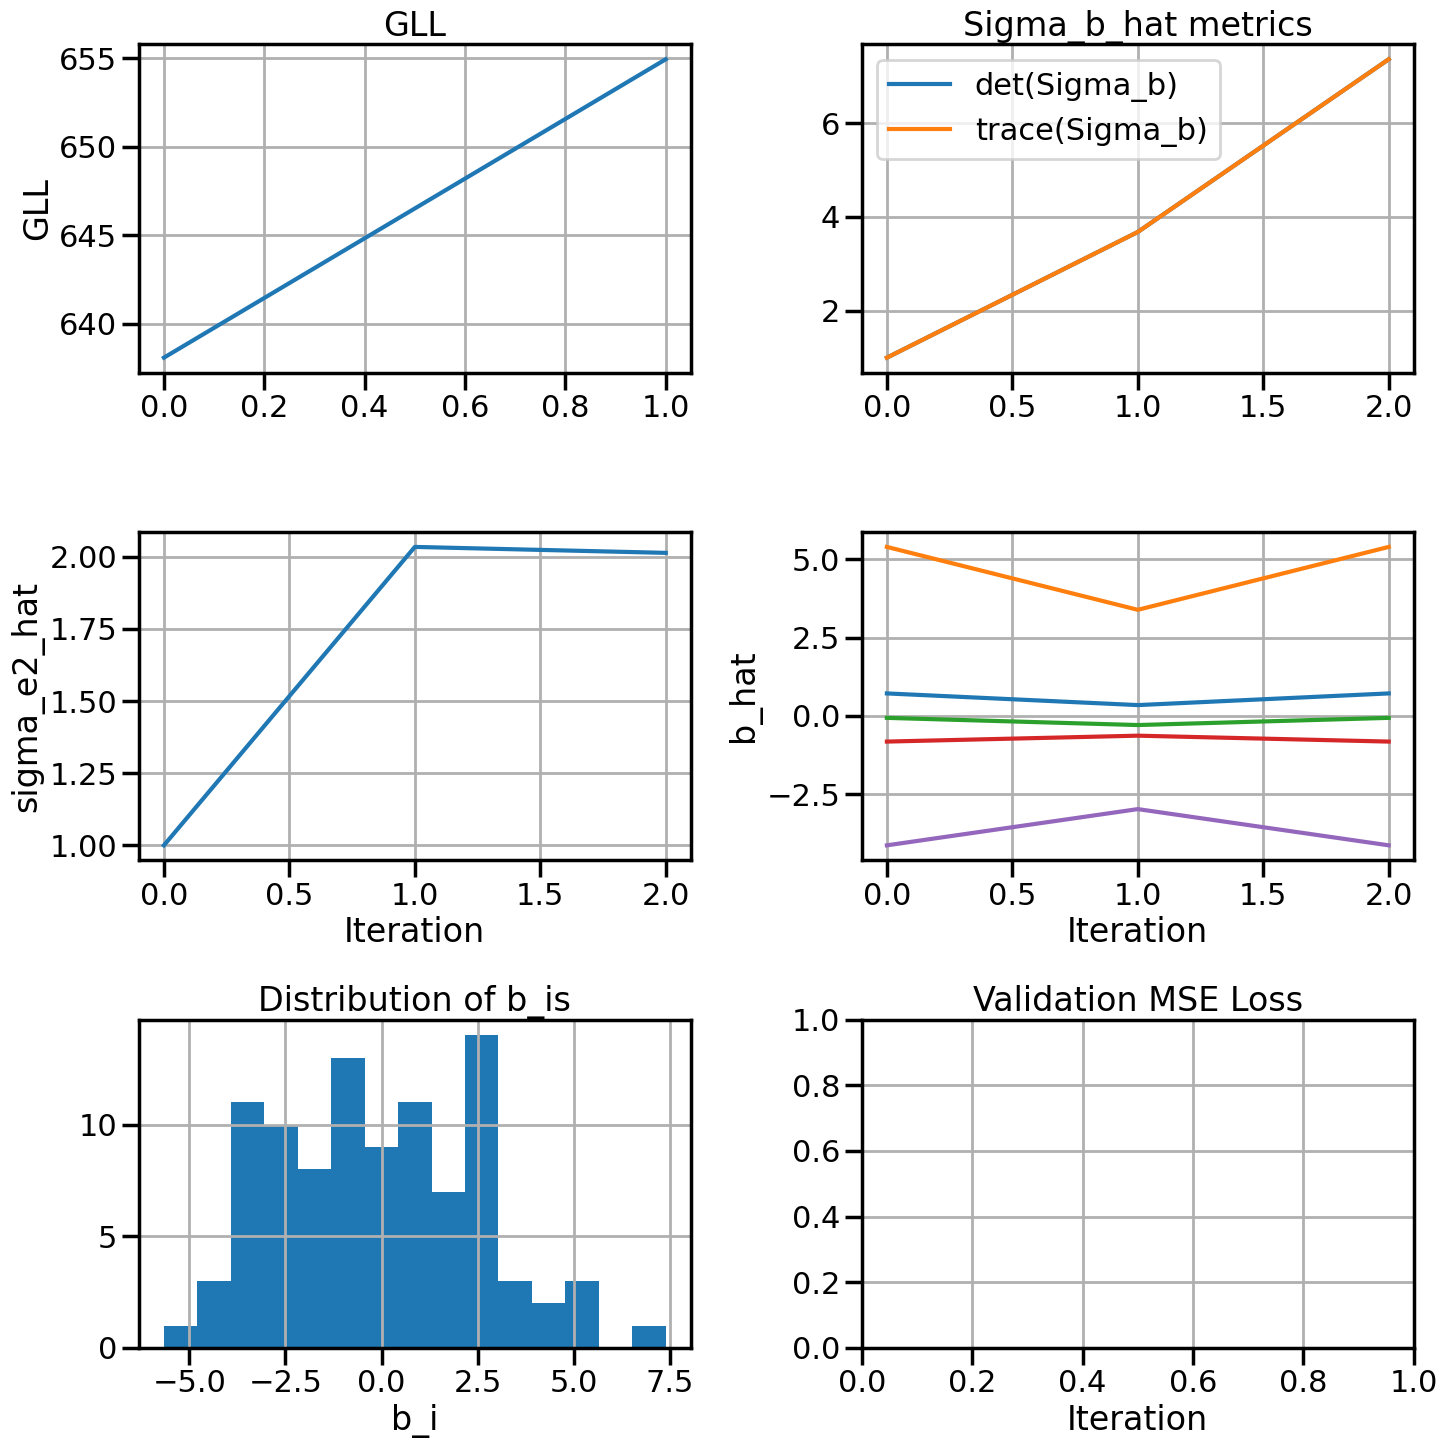

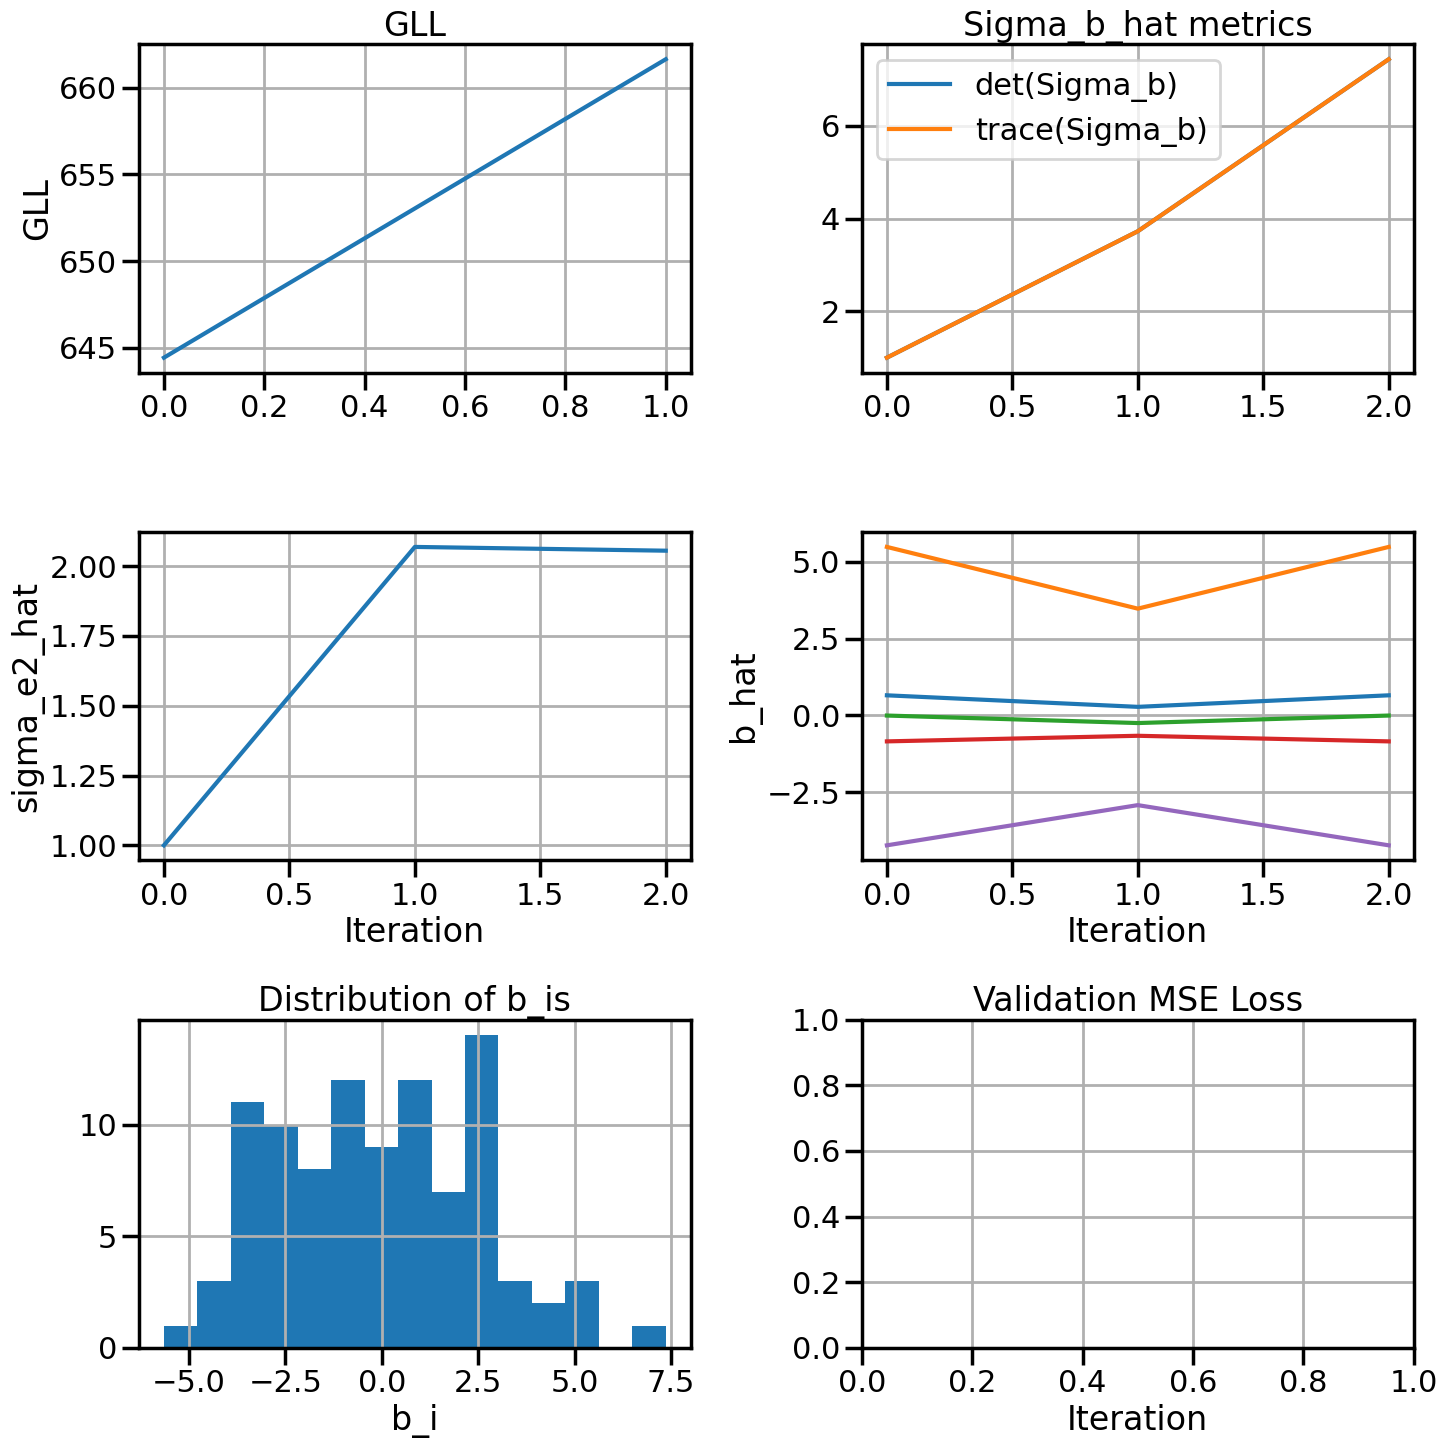

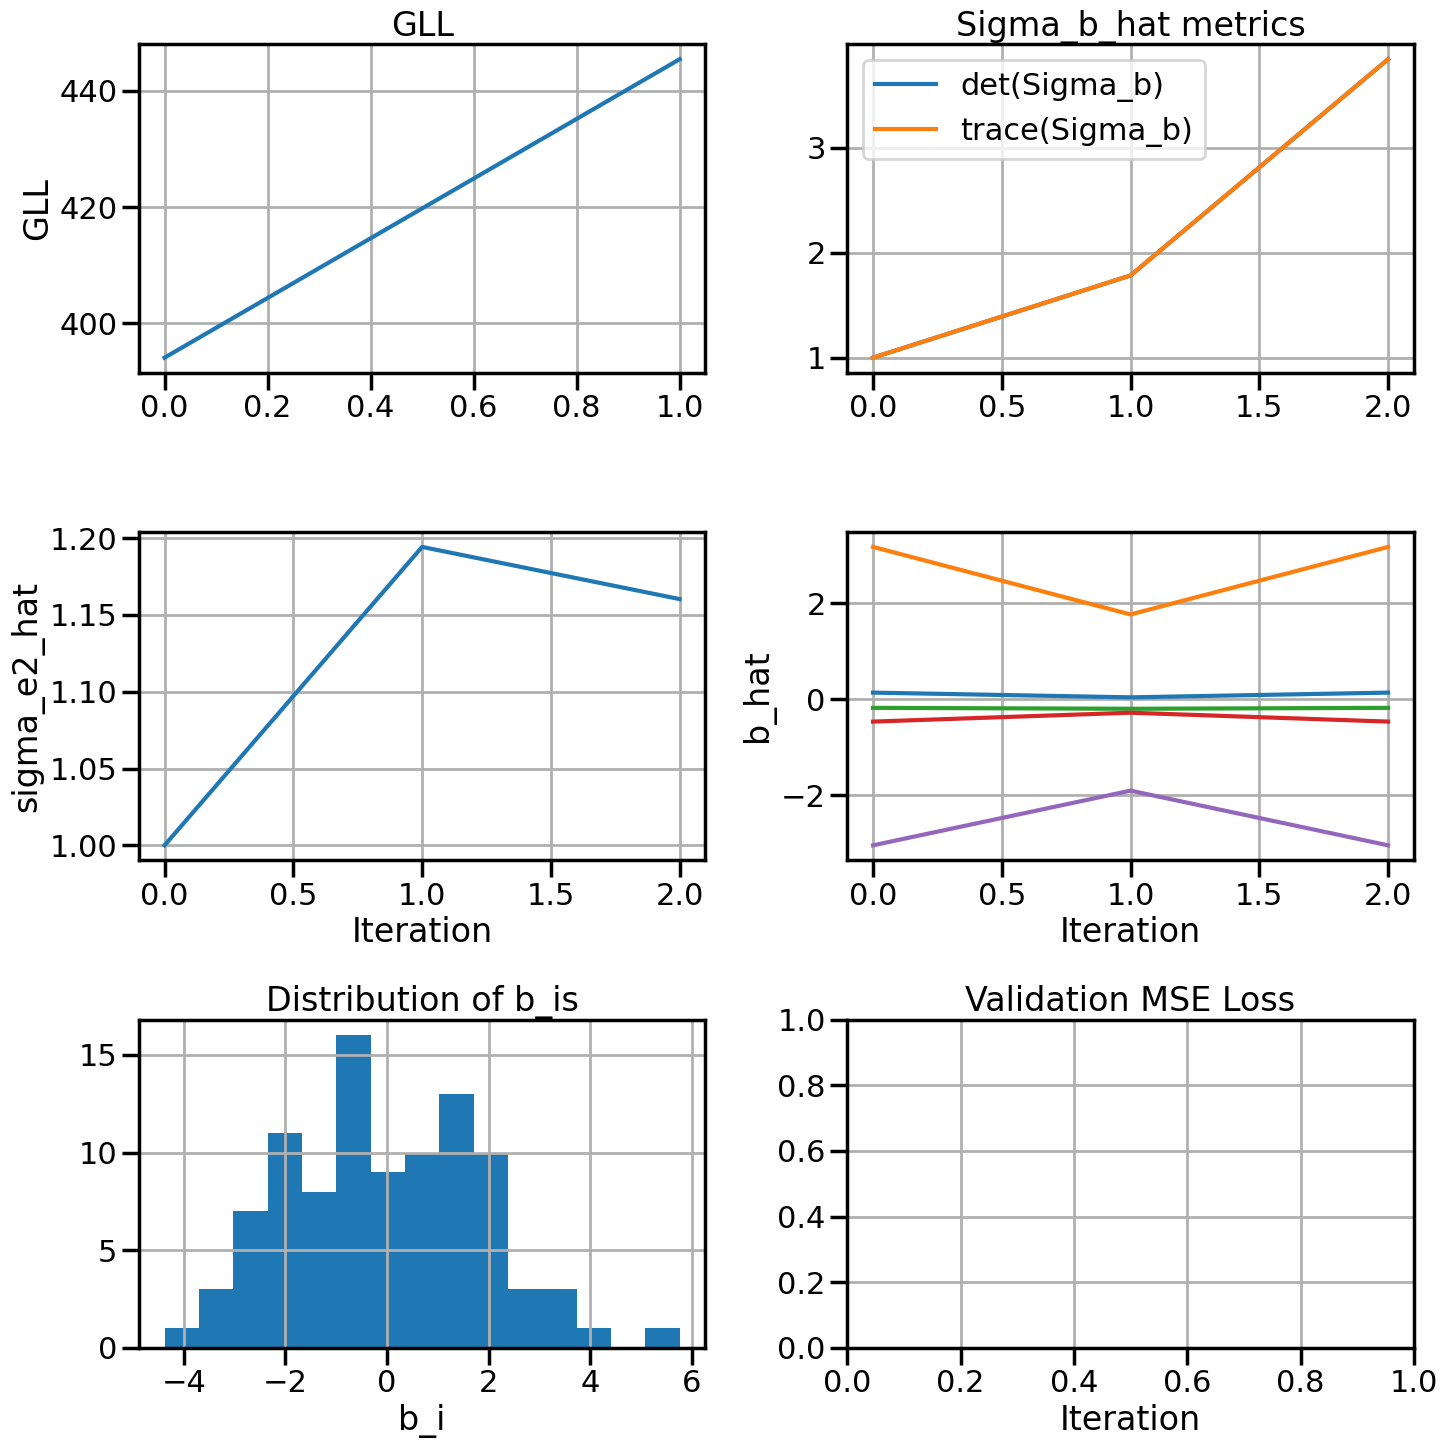

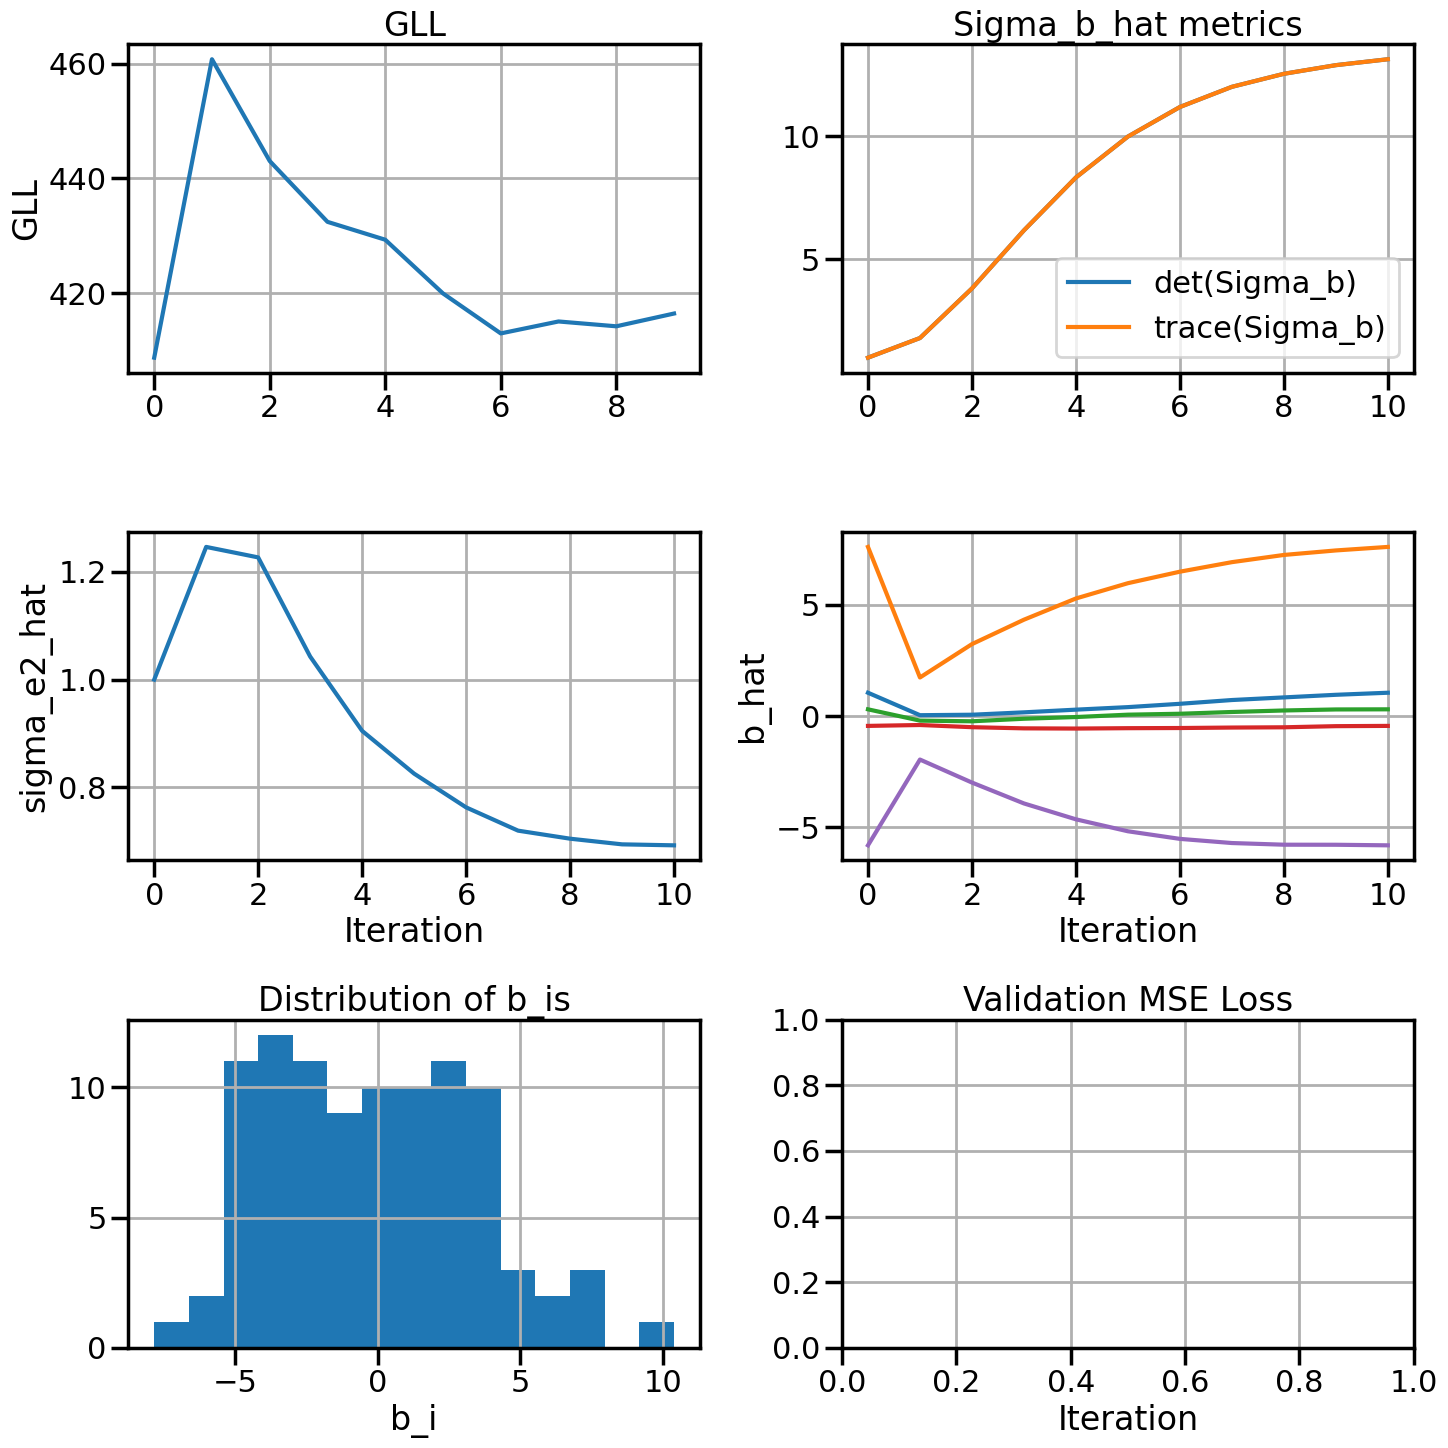

In [27]:
plot_merf_training_stats(mrf_mse)
plt.savefig(os.path.join(output_dir, 'cv_tuned_mse_merf_raw_metrics_all.png'), dpi=300, bbox_inches='tight')

plot_merf_training_stats(mrf_prev)
plt.savefig(os.path.join(output_dir, 'cv_tuned_prev_merf_raw_metrics_all.png'), dpi=300, bbox_inches='tight')

plot_merf_training_stats(mrf_ptev)
plt.savefig(os.path.join(output_dir, 'cv_tuned_ptev_merf_raw_metrics_all.png'), dpi=300, bbox_inches='tight')

plot_merf_training_stats(mrf_oob)
plt.savefig(os.path.join(output_dir, 'cv_tuned_oob_merf_raw_metrics_all.png'), dpi=300, bbox_inches='tight')

# Make predictions using the fitted models 

In [28]:
# Predict using the fitted model
clusters_new = pd.Series(test_set['all_samples'])
X_new = X_new.drop(columns=['x_t'], errors='ignore')
y_hat_new_mse = mrf_mse.predict(X_new, Z_new, clusters_new)
forest_mse = mrf_mse.trained_fe_model
oob_score_mse = round(forest_mse.oob_score_*100, 1)

y_hat_new_prev = mrf_prev.predict(X_new, Z_new, clusters_new)
forest_prev = mrf_prev.trained_fe_model
oob_score_prev = round(forest_prev.oob_score_*100, 1)

y_hat_new_ptev = mrf_ptev.predict(X_new, Z_new, clusters_new)
forest_ptev = mrf_ptev.trained_fe_model
oob_score_ptev = round(forest_ptev.oob_score_*100, 1)

y_hat_new_oob = mrf_oob.predict(X_new, Z_new, clusters_new)
forest_oob = mrf_oob.trained_fe_model
oob_score_tuned = round(forest_oob.oob_score_*100, 1)

# Plot predicted vs actual 

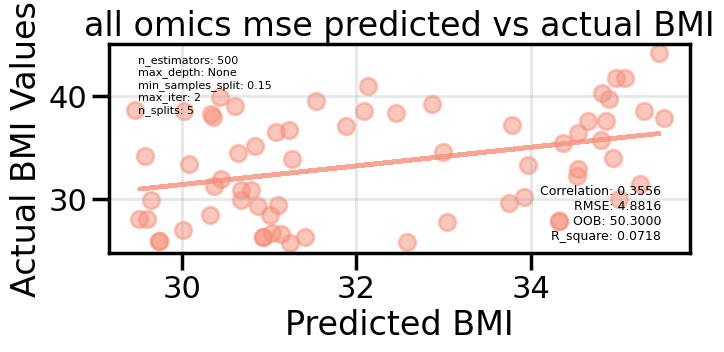

In [29]:
plot_predicted_vs_actual(y_hat_new_mse, Y_new,
                         output_dir, 'all_predicted_vs_actual_mse_tuned.png', 
                         best_mse_param_grid, oob_score_mse, '#F88F79', 'all omics mse predicted vs actual BMI')

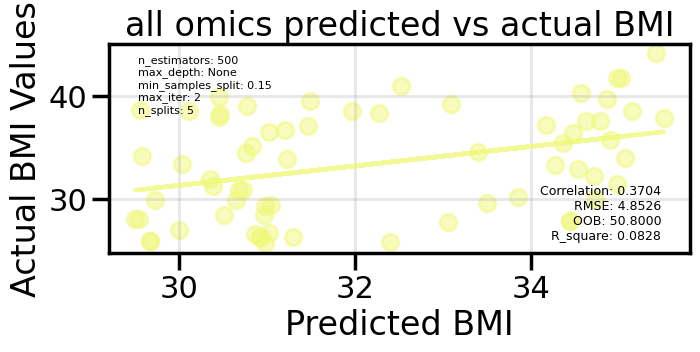

In [30]:
plot_predicted_vs_actual(y_hat_new_prev, Y_new,
                         output_dir, 'all_predicted_vs_actual_prev_tuned.png', 
                         lowest_prev_param_grid, oob_score_prev, '#F0F879', 'all omics predicted vs actual BMI')

Correlation between actual and predicted values: 0.3909
Root Mean Squared Error: 4.8066
R-squared Score: 0.1001


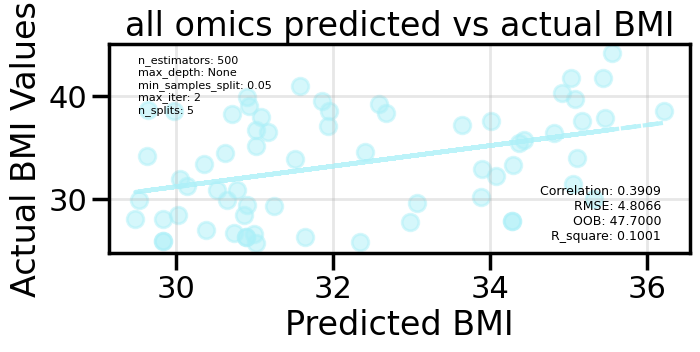

In [31]:
calculate_metrics(Y_new, y_hat_new_ptev) #(Y_true, Y_pred)
plot_predicted_vs_actual(y_hat_new_ptev, Y_new,
                         output_dir, 'all_predicted_vs_actual_ptev_tuned.png', 
                         lowest_ptev_param_grid, oob_score_ptev, '#ACF0F8', 'all omics predicted vs actual BMI')

Correlation between actual and predicted values: 0.3121
Root Mean Squared Error: 4.9174
R-squared Score: 0.0582


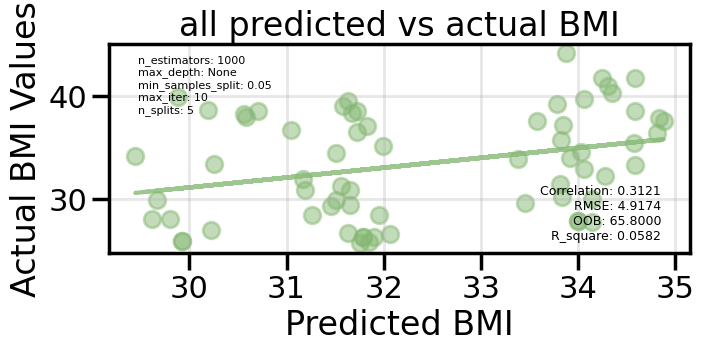

In [32]:
calculate_metrics(Y_new, y_hat_new_oob) #(Y_true, Y_pred)
plot_predicted_vs_actual(y_hat_new_oob, Y_new,
                         output_dir, 'all_predicted_vs_actual_oob_tuned.png', 
                         highest_oob_param_grid, oob_score_tuned, '#86B874', 'all predicted vs actual BMI')

### Look at feature importances 

Top 20 feature importances for best MSE parameters:
randomized_group: 0.0
cohort_number: 0.0058612315903291455
sex: 0.0
race: 0.0
age: 0.0004925314706037184
Glucose: 0.005294102295803071
HDL_Total_Direct_lipid: 0.001676156497843596
HOMA_IR: 0.5613887247915038
Insulin_endo: 0.09091426141429199
LDL_Calculated: 0.00047805541119760913
Triglyceride_lipid: 0.0066366234686332185
proton: 0.0
Diacetyl: 9.92824519855677e-05
Butyrate: 4.688221756929686e-05
Formate: 5.874524210291822e-05
acetone: 0.0003081817063276903
X2.methylbutyrate: 0.001310679390342246
Valeric.Acid: 0.00014420109078036415
Methane: 0.00020142411410842831
X1.4.Dihydroxy.2.naphthoate: 3.612394681123454e-05


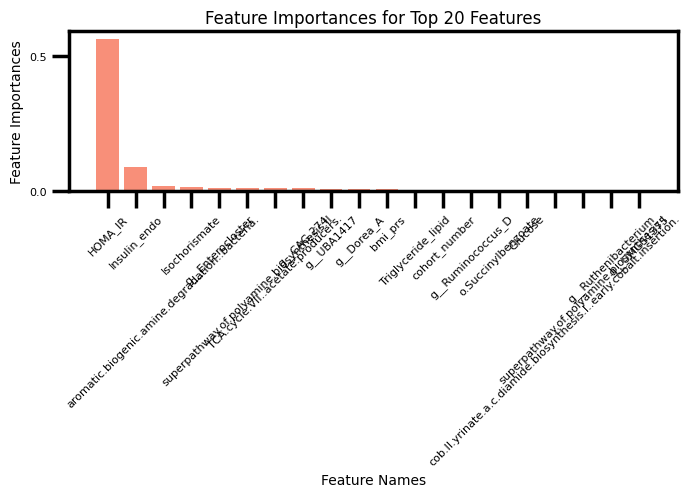

In [33]:
# mse
mse_forest = mrf_mse.trained_fe_model
mse_feature_names = mse_forest.feature_names_in_
mse_feature_importances = mse_forest.feature_importances_

print("Top 20 feature importances for best MSE parameters:")
for name, importance in zip(mse_feature_names[:20], 
                            mse_feature_importances[:20]):
    print(f"{name}: {importance}")

plot_top_20_feature_importances(mse_feature_names, mse_feature_importances, 
                         output_dir, 'mse_feature_importances_all', '#F88F79')

Top 20 feature importances for best PREV parameters:
randomized_group: 0.0
cohort_number: 0.008466252131682464
sex: 0.0
race: 1.923495602369268e-05
age: 0.0004532769083873223
Glucose: 0.006189340051103725
HDL_Total_Direct_lipid: 0.0008267035624840537
HOMA_IR: 0.5877308632583552
Insulin_endo: 0.07227080291441924
LDL_Calculated: 6.475143871303993e-05
Triglyceride_lipid: 0.004779043140002767
proton: 0.0
Diacetyl: 0.00021140012677344267
Butyrate: 0.0
Formate: 0.0
acetone: 0.00029425084623535905
X2.methylbutyrate: 0.001726066715630378
Valeric.Acid: 0.0
Methane: 3.582120143733855e-05
X1.4.Dihydroxy.2.naphthoate: 7.567209455452333e-05


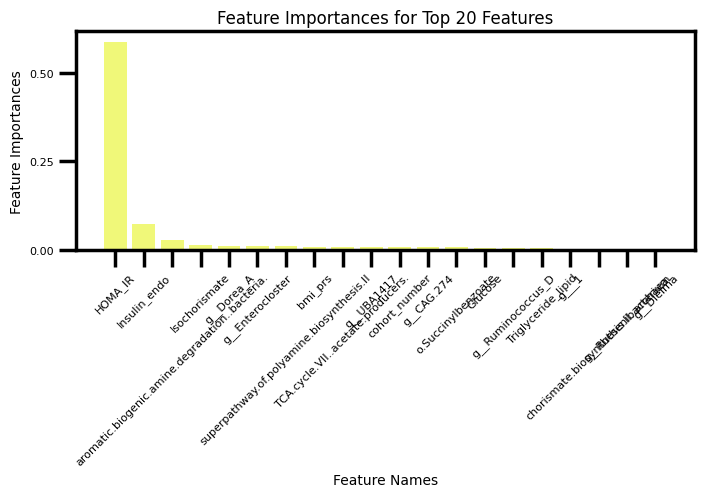

In [34]:
prev_forest = prev_merf.trained_fe_model
prev_feature_names = prev_forest.feature_names_in_
prev_feature_importances = prev_forest.feature_importances_

print("Top 20 feature importances for best PREV parameters:")
for name, importance in zip(prev_feature_names[:20], 
                            prev_feature_importances[:20]):
    print(f"{name}: {importance}")

plot_top_20_feature_importances(prev_feature_names, prev_feature_importances, 
                         output_dir, 'prev_feature_importances_all', '#F0F879')

Top 20 feature importances for best PTEV parameters:
randomized_group: 3.642503864058537e-05
cohort_number: 0.009756522153437188
sex: 2.5934756190977667e-05
race: 9.675842676002627e-05
age: 0.001495272200946019
Glucose: 0.006792855694600466
HDL_Total_Direct_lipid: 0.0015436909387423297
HOMA_IR: 0.345093497715131
Insulin_endo: 0.08803662198126401
LDL_Calculated: 0.0019254133776244206
Triglyceride_lipid: 0.012039667388311635
proton: 0.00026614297533689667
Diacetyl: 0.0006108549522596322
Butyrate: 0.00018535459620201583
Formate: 0.0006932825987290056
acetone: 0.0005275018906488512
X2.methylbutyrate: 0.0016401642736681907
Valeric.Acid: 0.00020598551204713045
Methane: 0.0002805992283992614
X1.4.Dihydroxy.2.naphthoate: 0.0005386122440377604


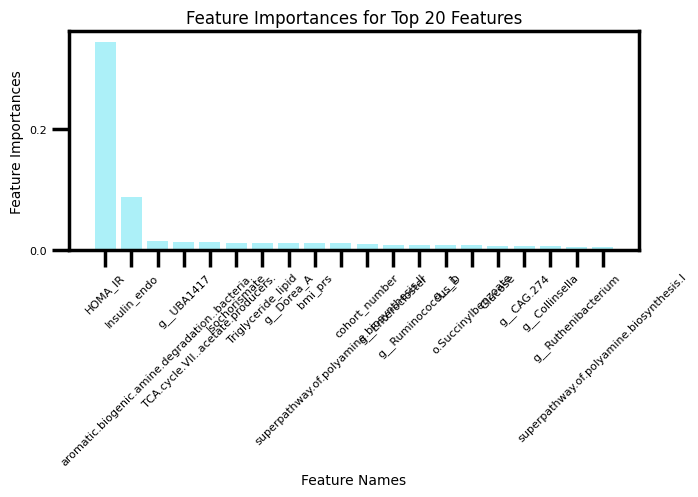

In [35]:
ptev_forest = ptev_merf.trained_fe_model
ptev_feature_names = ptev_forest.feature_names_in_
ptev_feature_importances = ptev_forest.feature_importances_

print("Top 20 feature importances for best PTEV parameters:")
for name, importance in zip(ptev_feature_names[:20], 
                            ptev_feature_importances[:20]):
    print(f"{name}: {importance}")

plot_top_20_feature_importances(ptev_feature_names, ptev_feature_importances, 
                         output_dir, 'ptev_feature_importances_all', '#ACF0F8')

Top 20 feature importances for best OOB parameters:
randomized_group: 0.00013833592774711604
cohort_number: 0.0002789956309144147
sex: 2.084777597480611e-05
race: 0.00030809449047359454
age: 0.00022981794867998675
Glucose: 0.0011894175147373958
HDL_Total_Direct_lipid: 0.0006810544759302032
HOMA_IR: 0.6897463592269198
Insulin_endo: 0.007588996869787696
LDL_Calculated: 0.00038302147044863897
Triglyceride_lipid: 0.00458150106855143
proton: 0.00046855178995525463
Diacetyl: 0.00030390136634005614
Butyrate: 0.0003961446575287478
Formate: 0.0002714713367780203
acetone: 0.0002100732999161042
X2.methylbutyrate: 0.0021644082988110536
Valeric.Acid: 0.0001550120769088245
Methane: 0.00014315255452671308
X1.4.Dihydroxy.2.naphthoate: 0.00016520498802065052


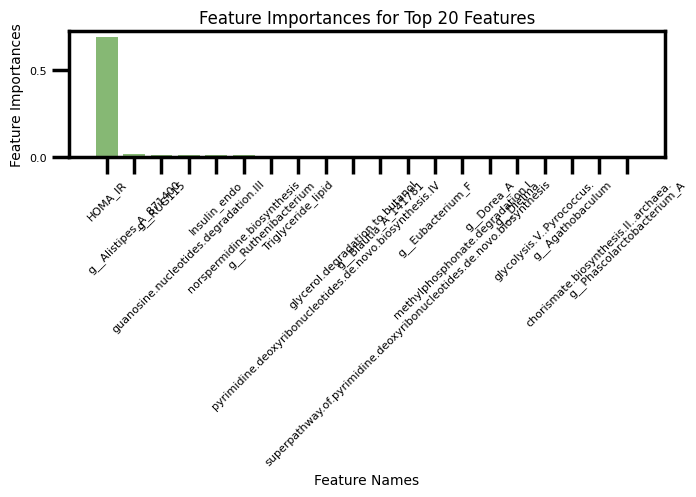

In [36]:
oob_forest = oob_merf.trained_fe_model
oob_feature_names = oob_forest.feature_names_in_
oob_feature_importances = oob_forest.feature_importances_

print("Top 20 feature importances for best OOB parameters:")
for name, importance in zip(oob_feature_names[:20], 
                            oob_feature_importances[:20]):
    print(f"{name}: {importance}")

plot_top_20_feature_importances(oob_feature_names, oob_feature_importances, 
                         output_dir, 'oob_feature_importances_all', '#86B874')